In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPool2D, 
    Conv2DTranspose, Concatenate, Add, Reshape, ConvLSTM2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import glob

2025-10-30 20:10:35.621092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761855035.875114   18451 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761855035.945484   18451 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# --- 1. GLOBAL PARAMETERS ---

# Image dimensions for resizing
SIZE_Y = 576
SIZE_X = 1024
# 12 Classes Total:
# 11 Classes Total:
# 0: Background
# 1: Crack
# 2: Rebar
# 3: Wall (Component 0)
# 4: Beam (Component 1)
# 5: Column (Component 2)
# 6: Window Frame (Component 3)
# 7: Window Pane (Component 4)
# 8: Balcony (Component 5)
# 9: Slab (Component 6)
# 10: Ignore (Component 100)
N_CLASSES = 11

# Training parameters
# WARNING: (576, 1024) is a large image. 
# ConvLSTM2D is very memory-heavy. Batch size 1 or 2 is recommended.
BATCH_SIZE = 2
EPOCHS = 100

# File paths
# *** UPDATE THESE PATHS to your directory structure ***
BASE_DIR = "/kaggle/input/quakecity/QuakeCity"  # Main folder containing all data
IMAGE_DIR = os.path.join(BASE_DIR, "image")
CRACK_DIR = os.path.join(BASE_DIR, "label/crack")
REBAR_DIR = os.path.join(BASE_DIR, "label/rebar")
COMPONENT_DIR = os.path.join(BASE_DIR, "label/component") # Folder containing 7 sub-folders
TRAIN_CSV = os.path.join(BASE_DIR, "train.csv")
TEST_CSV = os.path.join(BASE_DIR, "test.csv")





In [7]:
# --- 2. CUSTOM DATA GENERATOR ---

class DataGenerator(Sequence):
    """
    Generates batches of data for Keras.
    Reads image names from a dataframe, loads images, and dynamically creates
    11-class masks by combining 'cracks', 'rebars', and component masks.
    """
    def __init__(self, image_ids, image_dir, crack_dir, rebar_dir, component_dir,
                 batch_size, n_classes, shuffle=True):
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.crack_dir = crack_dir
        self.rebar_dir = rebar_dir
        self.component_dir = component_dir
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        # Use np.ceil to ensure that partial batches are also counted
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.image_ids[k] for k in indices]
        X, y = self.__data_generation(batch_ids)
        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        """Generates data containing batch_size samples"""
        X = np.empty((self.batch_size, SIZE_Y, SIZE_X, 3))
        y = np.empty((self.batch_size, SIZE_Y, SIZE_X, self.n_classes))

        for i, fname in enumerate(batch_ids):
            # --- Load and process image ---
            img_path = os.path.join(self.image_dir, fname)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (SIZE_X, SIZE_Y))
            X[i,] = img / 255.0

            # --- Load and combine masks ---
            # 1. Start with background (Class 0)
            mask = np.zeros((SIZE_Y, SIZE_X), dtype=np.uint8)

            # 2. Load Component Mask (Classes 3-9 and 10)
            comp_path = os.path.join(self.component_dir, fname)
            if os.path.exists(comp_path):
                comp_mask = cv2.imread(comp_path, cv2.IMREAD_GRAYSCALE)
                comp_mask = cv2.resize(comp_mask, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST)
                
                # Remap component mask pixels to our final class indices
                # 0 -> 3 (wall)
                # 1 -> 4 (beam)
                # 2 -> 5 (column)
                # 3 -> 6 (window frame)
                # 4 -> 7 (window pane)
                # 5 -> 8 (balcony)
                # 6 -> 9 (slab)
                # 100 -> 10 (ignore)
                
                conditions = [
                    (comp_mask == 0), (comp_mask == 1), (comp_mask == 2),
                    (comp_mask == 3), (comp_mask == 4), (comp_mask == 5),
                    (comp_mask == 6), (comp_mask == 100)
                ]
                choices = [3, 4, 5, 6, 7, 8, 9, 10]
                mask = np.select(conditions, choices, default=0)

            # 3. Add Rebars (Class 2) - Overwrites components
            rebar_path = os.path.join(self.rebar_dir, fname)
            if os.path.exists(rebar_path):
                rebar_mask = cv2.imread(rebar_path, cv2.IMREAD_GRAYSCALE)
                rebar_mask = cv2.resize(rebar_mask, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST)
                mask[rebar_mask > 0] = 2

            # 4. Add Cracks (Class 1) - Highest priority (overwrites all)
            crack_path = os.path.join(self.crack_dir, fname)
            if os.path.exists(crack_path):
                crack_mask = cv2.imread(crack_path, cv2.IMREAD_GRAYSCALE)
                crack_mask = cv2.resize(crack_mask, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST)
                mask[crack_mask > 0] = 1

            # 5. Re-apply Ignore mask (Class 10) - Highest priority
            if 'comp_mask' in locals():
                 mask[comp_mask == 100] = 10

            # One-hot encode the final 11-class mask
            y[i,] = to_categorical(mask, num_classes=self.n_classes)
            
        return X, y

In [8]:
# --- 3. LOSS & METRICS ---

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Dice coefficient metric for multiclass segmentation.
    Ignores Background (class 0) and Ignore (class 10).
    Calculates Dice for classes 1 through 9.
    """
    # *** FIX: Explicitly cast y_true to float32 to match y_pred's type ***
    y_true = tf.cast(y_true, tf.float32)

    # y_true is one-hot, y_pred is softmax
    # Select classes of interest (1 to 9)
    y_true_f = K.batch_flatten(y_true[..., 1:10])
    y_pred_f = K.batch_flatten(y_pred[..., 1:10])
    
    intersection = K.sum(y_true_f * y_pred_f, axis=-1)
    sum_scores = K.sum(y_true_f, axis=-1) + K.sum(y_pred_f, axis=-1)
    
    dice = (2. * intersection + smooth) / (sum_scores + smooth)
    return K.mean(dice) # Average over batch

def dice_loss(y_true, y_pred):
    """
    Dice loss function. Returns 1 - dice_coefficient.
    """
    return 1 - dice_coefficient(y_true, y_pred)


In [9]:
# --- 4. MODEL ARCHITECTURE (R2-U-Net) ---

def recurrent_conv_block(input_tensor, num_filters):
    """
    Recurrent Convolutional Block (for Encoder)
    Replaces the second Conv2D with a ConvLSTM2D for recurrence.
    """
    # Standard first conv
    x = Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Add recurrent layer
    shape = K.int_shape(x)
    # (batch, H, W, C) -> (batch, 1, H, W, C)
    if shape[0] is None:
        shape = (-1, 1, shape[1], shape[2], shape[3])
    else:
        shape = (shape[0], 1, shape[1], shape[2], shape[3])
        
    x_expanded = Reshape(shape[1:])(x)
    
    x_lstm = ConvLSTM2D(num_filters, 3, padding="same", return_sequences=False)(x_expanded)
    x_lstm = BatchNormalization()(x_lstm)
    x_lstm = Activation("relu")(x_lstm)
    
    return x_lstm

def conv_block(input_tensor, num_filters):
    """Standard Convolutional Block (for Decoder)"""
    x = Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input_tensor, num_filters):
    """Encoder block: Recurrent-Conv block followed by maxpooling"""
    x = recurrent_conv_block(input_tensor, num_filters) 
    p = MaxPool2D((2, 2))(x)
    return x, p   

def decoder_block(input_tensor, skip_features, num_filters):
    """Decoder block: Upsampling, skip connection, and standard Conv block"""
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters) 
    return x

def build_r2_unet(input_shape, n_classes):
    """Build the Recurrent-Encoder U-Net (R2-U-Net)"""
    inputs = Input(input_shape)

    base_channel = 16

    # Encoder (using recurrent_conv_block)
    s1, p1 = encoder_block(inputs, base_channel)
    s2, p2 = encoder_block(p1, base_channel*2)
    s3, p3 = encoder_block(p2, base_channel*4)
    s4, p4 = encoder_block(p3, base_channel*8)

    # Bridge (standard conv_block)
    b1 = conv_block(p4, base_channel*16) 

    # Decoder (using standard conv_block)
    d1 = decoder_block(b1, s4, base_channel*8)
    d2 = decoder_block(d1, s3, base_channel*4)
    d3 = decoder_block(d2, s2, base_channel*2)
    d4 = decoder_block(d3, s1, 64)

    # Output layer
    outputs = Conv2D(n_classes, 1, padding="same", activation="softmax")(d4)
    
    model = Model(inputs, outputs, name="Recurrent-Encoder-U-Net")
    return model


In [10]:
# --- 5. UTILITY FUNCTIONS ---

def load_data(train_csv_path, test_csv_path):
    """Loads training and testing image filenames from CSVs"""
    try:
        # Read CSVs assuming NO header row.
        df_train = pd.read_csv(train_csv_path, header=None)
        df_test = pd.read_csv(test_csv_path, header=None)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure train.csv and test.csv exist at the specified paths.")
        return None, None
        
    # Access the first column by its integer index (0).
    train_ids = df_train[0].values
    test_ids = df_test[0].values
    
    return train_ids, test_ids

def plot_history(log_file):
    """Plots training & validation metrics from log file"""
    if os.path.exists(log_file):
        print("Plotting from CSV log file...")
        log_df = pd.read_csv(log_file)
        
        plt.figure(figsize=(18, 6))
        
        # Plot Loss
        plt.subplot(1, 3, 1)
        plt.plot(log_df['epoch'] + 1, log_df['loss'], 'y', label='Training Dice Loss')
        plt.plot(log_df['epoch'] + 1, log_df['val_loss'], 'r', label='Validation Dice Loss')
        plt.title('Training and Validation Loss (Dice)')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot Dice Coefficient
        plt.subplot(1, 3, 2)
        plt.plot(log_df['epoch'] + 1, log_df['dice_coefficient'], 'y', label='Training Dice Coeff')
        plt.plot(log_df['epoch'] + 1, log_df['val_dice_coefficient'], 'r', label='Validation Dice Coeff')
        plt.title('Training and Validation Dice Coefficient')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Coeff')
        plt.legend()

        # Plot Mean IoU
        plt.subplot(1, 3, 3)
        plt.plot(log_df['epoch'] + 1, log_df['mean_io_u'], 'y', label='Training mIoU')
        plt.plot(log_df['epoch'] + 1, log_df['val_mean_io_u'], 'r', label='Validation mIoU')
        plt.title('Training and Validation Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('mIoU')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print("No log file found to plot.")

def get_true_and_pred_masks(generator, model):
    """Extracts all true masks and predicted masks from a generator"""
    print("Extracting true masks and predictions from generator...")
    y_true_all = []
    y_pred_all = []

    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        y_pred_batch = model.predict(X_batch, verbose=0)
        
        y_pred_argmax = np.argmax(y_pred_batch, axis=3)
        y_true_argmax = np.argmax(y_batch, axis=3)
        
        y_pred_all.append(y_pred_argmax)
        y_true_all.append(y_true_argmax)

    return np.concatenate(y_true_all), np.concatenate(y_pred_all)

def calculate_and_print_iou(y_true, y_pred, n_classes):
    """Calculates and prints Mean IoU and per-class IoU"""
    print("\n--- Model Evaluation (on best weights) ---")
    iou_keras = tf.keras.metrics.MeanIoU(num_classes=n_classes)
    iou_keras.update_state(y_true, y_pred)
    
    print(f"Mean IoU (all 11 classes) = {iou_keras.result().numpy():.4f}")

    values = iou_keras.get_weights()[0]
    
    # Define class names based on our structure
    class_names = [
        "0 (BG)", "1 (Crack)", "2 (Rebar)",
        "3 (Wall)", "4 (Beam)", "5 (Column)", "6 (Window Frame)",
        "7 (Window Pane)", "8 (Balcony)", "9 (Slab)", "10 (Ignore)"
    ]

    iou_list = []
    for i in range(n_classes):
        tp = values[i, i]
        fp = np.sum(values[:, i]) - tp
        fn = np.sum(values[i, :]) - tp
        
        iou = tp / (tp + fp + fn + K.epsilon())
        iou_list.append(iou)
        print(f"IoU for {class_names[i]}: {iou:.4f}")
        
    # Calculate Mean IoU for classes of interest (1-9)
    iou_interest = np.mean(iou_list[1:10])
    print(f"\nMean IoU (Classes of Interest 1-9): {iou_interest:.4f}")


def plot_predictions(generator, model, num_to_plot=3):
    """Plots a few sample predictions"""
    print("\n--- Visualizing Predictions ---")
    X_batch, y_batch = generator[0]
    y_pred_batch = model.predict(X_batch, verbose=0)
    
    y_true_argmax = np.argmax(y_batch, axis=3)
    y_pred_argmax = np.argmax(y_pred_batch, axis=3)
    
    for i in range(num_to_plot):
        if i >= len(X_batch):
            break
            
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(X_batch[i])
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title(f'True Mask (0-10 Classes)')
        plt.imshow(y_true_argmax[i], cmap='jet', vmin=0, vmax=N_CLASSES - 1)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(y_pred_argmax[i], cmap='jet', vmin=0, vmax=N_CLASSES - 1)
        plt.axis('off')
        
        plt.show()

In [11]:
# --- 6. SCRIPT EXECUTION (No main function) ---

In [12]:
# Setup GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Running on {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

Running on 1 GPU(s).


In [13]:
# Load data file names
print("Loading data...")
train_ids, test_ids = load_data(TRAIN_CSV, TEST_CSV)
if train_ids is None:
    print("Exiting due to data loading error.")
    exit()

print(f"Found {len(train_ids)} training images.")
print(f"Found {len(test_ids)} testing images.")

Loading data...
Found 3805 training images.
Found 1004 testing images.


In [14]:
# Split train IDs into train and validation
train_ids, val_ids = train_test_split(train_ids, test_size=0.1, random_state=42)

In [15]:
# Create data generators
print("Creating data generators...")
train_gen = DataGenerator(
    train_ids, IMAGE_DIR, CRACK_DIR, REBAR_DIR, COMPONENT_DIR,
    BATCH_SIZE, N_CLASSES, shuffle=True
)

val_gen = DataGenerator(
    val_ids, IMAGE_DIR, CRACK_DIR, REBAR_DIR, COMPONENT_DIR,
    BATCH_SIZE, N_CLASSES, shuffle=False
)

test_gen = DataGenerator(
    test_ids, IMAGE_DIR, CRACK_DIR, REBAR_DIR, COMPONENT_DIR,
    BATCH_SIZE, N_CLASSES, shuffle=False
)

Creating data generators...


In [16]:
print(f"Number of images in Training set: {len(train_ids)}")
print(f"Number of images in Validation set: {len(val_ids)}")
print(f"Number of images in Test set: {len(test_ids)}")

Number of images in Training set: 3424
Number of images in Validation set: 381
Number of images in Test set: 1004


In [17]:
# Build model
print("Building model...")
input_shape = (SIZE_Y, SIZE_X, 3) # 3 channels for RGB
model = build_r2_unet(input_shape, n_classes=N_CLASSES)

# Compile model
print("Compiling model with Dice Loss and mIoU metric...")
model.compile(
    optimizer='adam', 
    loss=dice_loss, 
    metrics=[dice_coefficient, tf.keras.metrics.MeanIoU(num_classes=N_CLASSES, name="mean_io_u")]
)

model.summary()

Building model...


I0000 00:00:1761855070.265977   18451 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Compiling model with Dice Loss and mIoU metric...


Model: "Recurrent-Encoder-U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 576, 1024, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 576, 1024, │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 576, 1024, │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 576, 1024, │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 576,    │          0 │ activation[0][0]  │
│                     │ 1024, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 576, 1024, │     18,496 │ reshape[0][0]     │
│ (ConvLSTM2D)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 576, 1024, │         64 │ conv_lstm2d[0][0] │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 576, 1024, │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 288, 512,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 288, 512,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 288, 512,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 288, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 288,    │          0 │ activation_2[0][… │
│                     │ 512, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 288, 512,  │     73,856 │ reshape_1[0][0]   │
│ (ConvLSTM2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 288, 512,  │        128 │ conv_lstm2d_1[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 288, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 144, 256,  │          0 │ activation_3[0][

 Total params: 2,579,051 (9.84 MB)

 Trainable params: 2,577,003 (9.83 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
# Output files
CHECKPOINT_PATH = "/kaggle/working/iscm_r2unet_best.weights.h5"
LOG_FILE = "/kaggle/working/iscm_r2unet_log.csv"

# Callbacks
callbacks = [
    ModelCheckpoint(
        CHECKPOINT_PATH, 
        verbose=1, 
        monitor='val_loss', # Monitor val_loss (dice loss)
        mode='min',         # Try to minimize the loss
        save_best_only=True,
        save_weights_only=True
    ),
    EarlyStopping(
        patience=10, 
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    CSVLogger(LOG_FILE, append=True)
]

# Check for checkpoint and resume training
initial_epoch = 0
if os.path.exists(CHECKPOINT_PATH):
    print(f"--- Resuming training from checkpoint: {CHECKPOINT_PATH} ---")
    model.load_weights(CHECKPOINT_PATH)
    
    if os.path.exists(LOG_FILE):
        try:
            log_df = pd.read_csv(LOG_FILE)
            initial_epoch = log_df['epoch'].iloc[-1] + 1
            print(f"Resuming from epoch {initial_epoch}")
        except (pd.errors.EmptyDataError, IndexError):
            print("Log file is empty. Starting from epoch 0.")
    else:
        print("Log file not found. Starting from epoch 0.")
else:
    print("--- Starting new training session ---")


# Train the model
print("Starting training...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    verbose=1
)

--- Resuming training from checkpoint: /kaggle/working/iscm_r2unet_best.weights.h5 ---
Resuming from epoch 4
Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 134 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 5/100


E0000 00:00:1761855592.538716   18485 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761855592.774926   18485 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761855593.100458   18485 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761855593.336845   18485 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761855594.595833   18485 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

 252/1712 ━━━━━━━━━━━━━━━━━━━━ 14:39 602ms/step - dice_coefficient: 0.5125 - loss: 0.4875 - mean_io_u: 0.4402

Plotting from CSV log file...


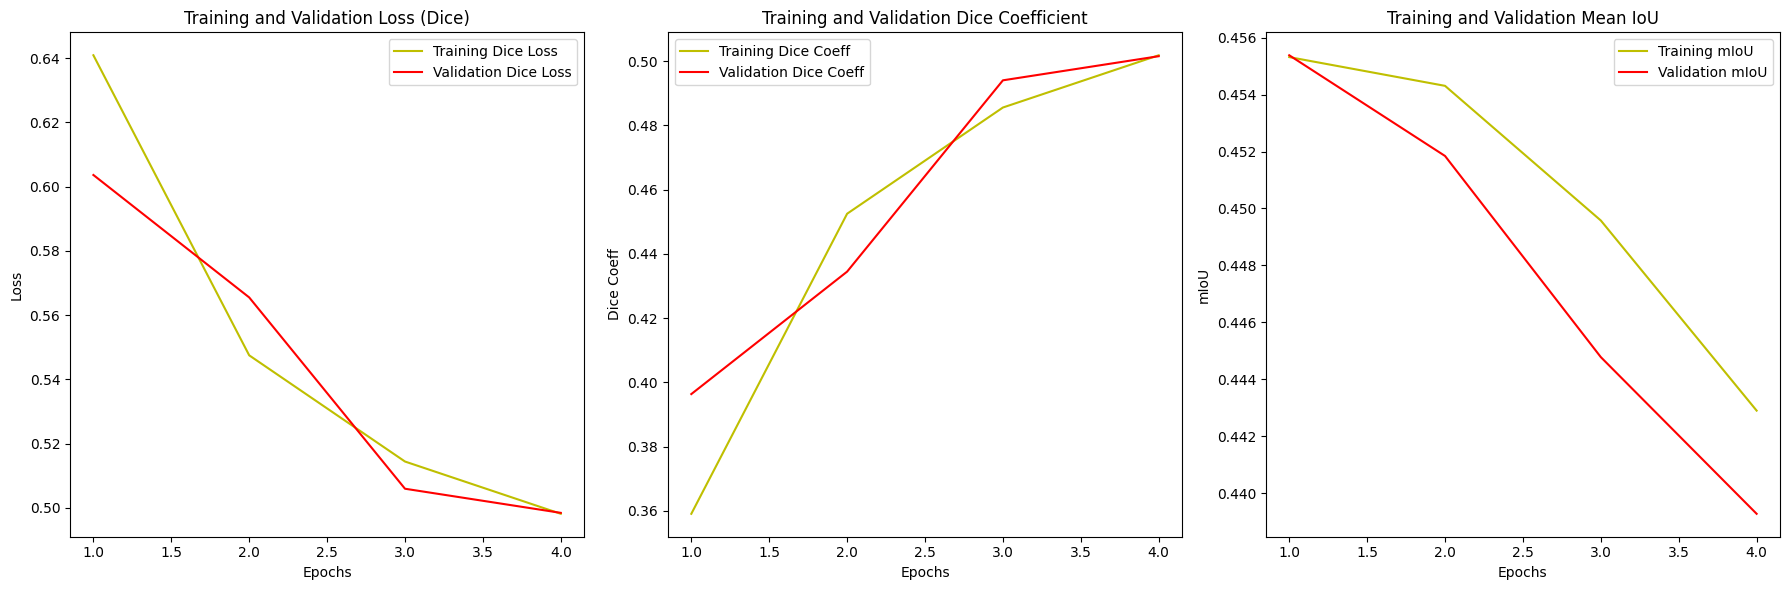

Loading best model for final evaluation...
Evaluating on TEST set (from test.csv)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


502/502 ━━━━━━━━━━━━━━━━━━━━ 292s 568ms/step - dice_coefficient: 0.5325 - loss: 0.4675 - mean_io_u: 0.4402
Test Loss: 0.4847 (Dice Loss)
Test Dice Coefficient: 0.5153
Test Mean IoU (all 11 classes): 0.4397


In [21]:
# --- Post-Training Evaluation ---

CHECKPOINT_PATH = "/kaggle/working/iscm_r2unet_best.weights.h5"
LOG_FILE = "/kaggle/working/iscm_r2unet_log.csv"

# Plot history from the log file
plot_history(LOG_FILE)

# Load the *best* model saved by ModelCheckpoint
print("Loading best model for final evaluation...")
# 1. First, build the empty model structure
best_model = build_r2_unet(input_shape, n_classes=N_CLASSES)

# 2. Second, load the saved weights into the structure
best_model.load_weights(CHECKPOINT_PATH)

# 3. Third, compile the model so .evaluate() works
best_model.compile(
    optimizer='adam', 
    loss=dice_loss, 
    metrics=[dice_coefficient, tf.keras.metrics.MeanIoU(num_classes=N_CLASSES, name="mean_io_u")]
)

# # Evaluate on Test Set
# print("Evaluating on TEST set (from test.csv)...")
# results = best_model.evaluate(test_gen, verbose=1)

# # Print evaluation results from model.evaluate()
# print(f"Test Loss: {results[0]:.4f} (Dice Loss)")
# print(f"Test Dice Coefficient: {results[1]:.4f}")
# print(f"Test Mean IoU (all 11 classes): {results[2]:.4f}")

# # Calculate detailed per-class IoU on the test set
# y_true_test, y_pred_test = get_true_and_pred_masks(test_gen, best_model)
# calculate_and_print_iou(y_true_test, y_pred_test, N_CLASSES)

# # Plot some predictions from the test set
# plot_predictions(test_gen, best_model, num_to_plot=3)